In [253]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy
from scipy.stats import zscore
from seaborn import kdeplot
from functions import *

In [2]:
# Load Congressional Tweets
C = pd.read_pickle("master_DF.pkl")

In [5]:
# Load Retweets
df = pd.read_pickle("master_RT_DF.pkl")
df["partisan_topic"] = df.CAP_Policy.apply(lambda x: top2party[x])
df = df[df.pol_count > 100]
R = df[df.weighted_pol > 0]
D =  df[df.weighted_pol < 0]

NameError: name 'top2party' is not defined

In [8]:
# Set threshold and subset by Republican and Democrat Tweets
THREH = 21 # Minimum engagements (ensures non-bias due to the max # of topics)
R = df[df.weighted_pol > 0]
R_users = R.rt_userid.value_counts()
R_users = R_users[R_users > THREH].index
R = R[R.rt_userid.isin(R_users)]

D =  df[df.weighted_pol < 0]
D_users = D.rt_userid.value_counts()
D_users = D_users[D_users > THREH].index
D = D[D.rt_userid.isin(D_users)]

In [9]:
# Count distributions on R and D
R_uni = R.groupby(["rt_userid", "CAP_Policy"])["max_pol"].count().reset_index()
R_uni = R_uni.rt_userid.value_counts()
R_uni, R_cnts = np.unique(R_uni.values, return_counts = True)

D_uni = D.groupby(["rt_userid", "CAP_Policy"])["max_pol"].count().reset_index()
D_uni = D_uni.rt_userid.value_counts()
D_uni, D_cnts = np.unique(D_uni.values, return_counts = True)

In [11]:
# Entropy computations for R and D
R_ent = R.groupby(["rt_userid", "CAP_Policy"])["max_pol"].count().reset_index()
R_ent["prop"] = R_ent.groupby("rt_userid")[["max_pol"]].transform(lambda x: x / x.sum())
R_ent["ent_comp"] = R_ent.groupby("rt_userid")[["prop"]].transform(lambda x: - x * np.log2(x))
R_ent = R_ent.groupby("rt_userid")["ent_comp"].sum().values
R_ent, R_distrib = np.unique( np.round(R_ent,2), return_counts = True)
R_ent = pd.DataFrame(np.vstack((R_ent,R_distrib)).T, columns = ["x", "y"])
R_ent.y = R_ent.y / R_ent.y.sum()
R_ent["y_cum"] = np.cumsum(R_ent.y )

D_ent = D.groupby(["rt_userid", "CAP_Policy"])["max_pol"].count().reset_index()
D_ent["prop"] = D_ent.groupby("rt_userid")[["max_pol"]].transform(lambda x: x / x.sum())
D_ent["ent_comp"] = D_ent.groupby("rt_userid")[["prop"]].transform(lambda x: - x * np.log2(x))
D_ent = D_ent.groupby("rt_userid")["ent_comp"].sum().values
D_ent, D_distrib = np.unique( np.round(D_ent,2), return_counts = True)
D_ent = pd.DataFrame(np.vstack((D_ent,D_distrib)).T, columns = ["x", "y"])
D_ent.y = D_ent.y / D_ent.y.sum()
D_ent["y_cum"] = np.cumsum(D_ent.y )

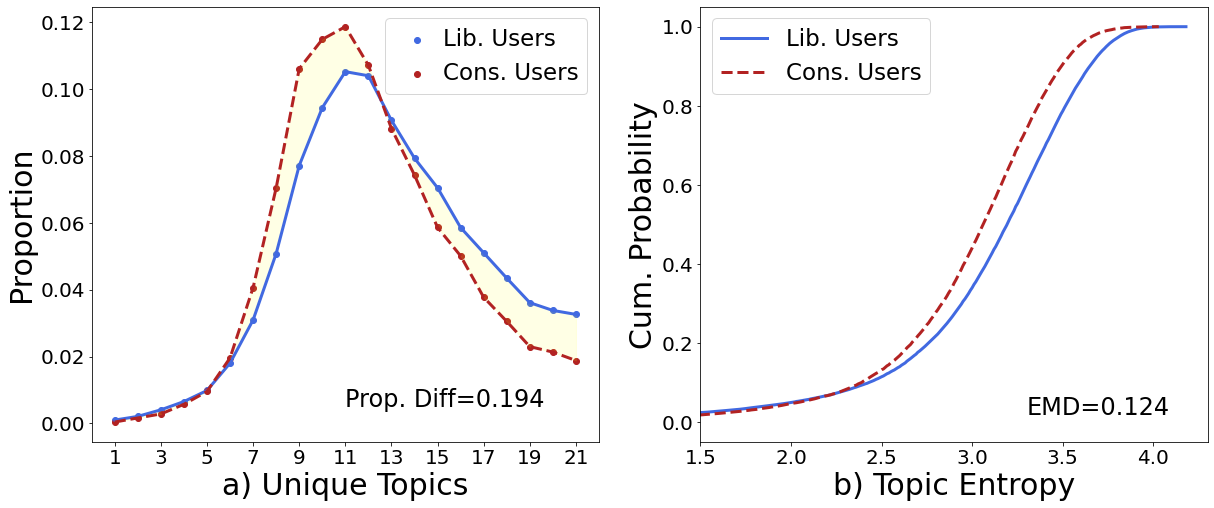

In [27]:
# Visualization of R and D
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.scatter(D_uni, D_cnts / D_cnts.sum(), label = "Lib. Users", color = "royalblue")
plt.scatter(R_uni, R_cnts / R_cnts.sum(), label = "Cons. Users", color = "firebrick")

plt.fill_between(D_uni, D_cnts / D_cnts.sum(), R_cnts / R_cnts.sum(), alpha=0.1, color = "yellow")

plt.plot(D_uni, D_cnts / D_cnts.sum(), color = "royalblue", linewidth=3)
plt.plot(R_uni, R_cnts / R_cnts.sum(), color = "firebrick", linewidth=3, linestyle="--")
plt.xticks(range(1,22,2),fontsize=20)
plt.xlabel("a) Unique Topics", fontsize=30)
plt.yticks(fontsize=20)
plt.ylabel("Proportion", fontsize=30)
plt.legend(fontsize=23,loc="upper right",handletextpad=0.1)
prop_diff = np.abs( D_cnts / D_cnts.sum() - R_cnts / R_cnts.sum() ).sum()
plt.annotate("Prop. Diff={}".format(np.round(prop_diff,3)), (11,0.005), fontsize=24)

plt.subplot(1,2,2)
plt.plot(D_ent.x, D_ent.y_cum, color = "royalblue", label = "Lib. Users", linewidth=3)
plt.plot(R_ent.x, R_ent.y_cum, color = "firebrick", label = "Cons. Users", linewidth=3, linestyle="--")

plt.xlim(1.5,4.3)
plt.xticks(fontsize=20)
plt.xlabel("b) Topic Entropy", fontsize=30)
plt.yticks(fontsize=20)
plt.ylabel("Cum. Probability", fontsize=30)
plt.legend(fontsize=23)

EMD = scipy.stats.wasserstein_distance(D_ent.x, R_ent.x, D_ent.y, R_ent.y)
plt.annotate("EMD={}".format(np.round(EMD,3)), (3.3,0.02), fontsize=24)

plt.savefig("figures/engagement_entropy-1.png")

In [478]:
%%time
U = df[df.pol_count > 5].copy()
U = U[["rt_userid","weighted_pol_binary"]]
U = U.drop_duplicates()

U_users = U.rt_userid.value_counts()
U_users = U_users[U_users > 4].index
UU = df[df.rt_userid.isin(U_users)]

U_ent = UU.groupby(["rt_userid", "weighted_pol_binary","CAP_Policy"])["max_pol"].count().reset_index()
UU = U_ent.copy()
U_ent["prop"] = U_ent.groupby("rt_userid")[["max_pol"]].transform(lambda x: x / x.sum())
U_ent["ent_comp"] = U_ent.groupby("rt_userid")[["prop"]].transform(lambda x: - x * np.log2(x))
U_ent = U_ent.groupby("rt_userid")["ent_comp"].sum().reset_index()
UU = U_ent.merge(UU[["rt_userid", "weighted_pol_binary"]].drop_duplicates("rt_userid"), how = "left")

UU = UU[~UU.weighted_pol_binary.apply(lambda x: np.abs(x) > 0.95)]

UU.weighted_pol_binary = np.round(UU.weighted_pol_binary, 1)
entropy = UU.groupby("weighted_pol_binary")[["ent_comp"]].mean().reset_index()

CPU times: user 24.4 s, sys: 1.98 s, total: 26.4 s
Wall time: 26.8 s


In [479]:
a0 = entropy.ent_comp.iloc[10]
aD = entropy.iloc[:10].ent_comp.values.reshape(5,2).mean(axis=1)
aR = entropy.iloc[11:].ent_comp.values.reshape(5,2).mean(axis=1)
aD = np.hstack(( aD, a0))[::-1]
aR = np.hstack(( a0, aR))

ValueError: cannot reshape array of size 9 into shape (5,2)

In [484]:
from statsmodels.nonparametric.smoothers_lowess import lowess

In [504]:
x1 = -entropy.weighted_pol_binary.values[1:11]
y1 = entropy.ent_comp.values[1:11]
x1, y1 = lowess(y1, x1).T

x2 = entropy.weighted_pol_binary.values[10:]
y2 = entropy.ent_comp.values[10:]
x2, y2 = lowess(y2, x2).T

Text(0, 0.5, 'Topic Entropy')

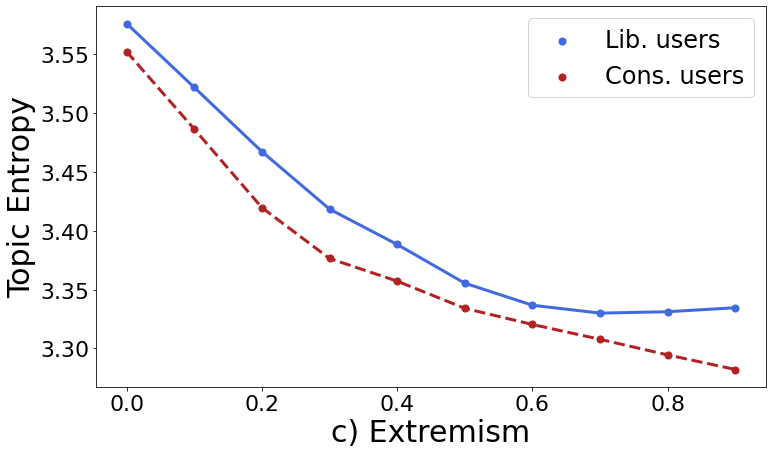

In [505]:
plt.figure(figsize=(12,7))
plt.plot(x1, y1, 
            color = "royalblue", linewidth=3,)
plt.plot(x2, y2, 
            color = "firebrick", linewidth=3, linestyle="--")
plt.scatter(x1, y1,
            label="Lib. users", color = "royalblue" , s=50)
plt.scatter(x2, y2,
            label="Cons. users", color = "firebrick", s=50)


plt.legend(fontsize=24)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel("c) Extremism", fontsize=30)
plt.ylabel("Topic Entropy", fontsize=30)